In [1]:
import pandas as pd
import numpy as np

In [2]:
am = pd.DataFrame.from_csv('Drug_expanded/drug-drug-AM.csv')

In [3]:
for c in am.columns:
        if not am[c].equals(am.loc[c]):
            print(c)

In [121]:
df = pd.DataFrame.from_csv('Train_data/clustered2.csv')

In [122]:
df['Target_share'] = ""
for i in range(df.shape[0]):
    df.set_value(i, 'Target_share', am.ix[df.ix[i, 'COMPOUND_A'], df.ix[i, 'COMPOUND_B']])
    #df['Target_share'][i] = am[df['COMPOUND_A'][i]][df['COMPOUND_B'][i]] 

In [123]:
df.columns

Index(['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B', 'MAX_CONC_A', 'MAX_CONC_B',
       'IC50_A', 'H_A', 'Einf_A', 'IC50_B', 'H_B', 'Einf_B', 'SYNERGY_SCORE',
       'A_HBA', 'A_cLogP', 'A_HBD', 'A_Lipinski', 'A_MW', 'A_ALogP/XLogP',
       'A_PSA', 'A_#RotBonds', 'A_Arom Rings', 'A_Heavy atoms', 'A_QED',
       'B_HBA', 'B_cLogP', 'B_HBD', 'B_Lipinski', 'B_MW', 'B_ALogP/XLogP',
       'B_PSA', 'B_#RotBonds', 'B_Arom Rings', 'B_Heavy atoms', 'B_QED',
       'GEX_CLUSTER', 'ORIGIN_CLUSTER', 'THERAPY_CLUSTER', 'Target_share'],
      dtype='object')

In [129]:
df.to_csv('Train_data/with_targets2.csv')

In [124]:
df = df.iloc[np.random.permutation(len(df))]
Ypd = df['SYNERGY_SCORE']
Xpd = pd.get_dummies(df.drop('SYNERGY_SCORE', axis=1), columns=['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B'])

#orig_data = pd.DataFrame.from_csv('Clean_data/train2.csv', header=0, index_col=None)
#df = df.iloc[np.random.permutation(len(orig_data))]
#Xpd = pd.get_dummies(df, columns=['CELL_LINE', 'COMPOUND_A', 'COMPOUND_B'])
#Ypd = orig_data['SYNERGY_SCORE'].reindex(Xpd.index)

Xvals = Xpd.values
yvals = Ypd.values

In [10]:
def print_scores(model):
    print("R^2: " + str(model.score(X_test, y_test)))
    print("RMSE: " + str(scoring.rmse(y_test, model.predict(X_test))) ) # root mean squared error
    print("MAE: " + str(metrics.mean_absolute_error(y_test, model.predict(X_test)))) # mean absolute error
    print("MAPE: " + str(scoring.mape(y_test, model.predict(X_test)))) # mean absolute percent error
    print("Error within 20: " + str(scoring.error_within(0.2, y_test, model.predict(X_test)))) # error within
    print("Pearson: " + str(stats.pearsonr(y_test, model.predict(X_test)))) # pearson correlation

## Training

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR, SVC
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
import scipy.stats as stats
import scoring

In [125]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xvals, yvals)

In [126]:
gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=7,
                                max_features='log2', learning_rate=0.03)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.03, loss='ls',
             max_depth=7, max_features='log2', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [127]:
print_scores(gbr)

R^2: 0.303345939352
RMSE: 38.27535550342086
MAE: 23.0766183463
MAPE: 3.83356707243
Error within 20: 0.489795918367
Pearson: (0.55289669457883595, 1.7725165894405088e-44)


In [132]:
r2s = []
pearsons = []
for i in range(10):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xvals, yvals)
    gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=7,
                                max_features='log2', learning_rate=0.03)
    gbr.fit(X_train, y_train)
    r2 = gbr.score(X_test, y_test)
    r2s.append(r2)
    p = stats.pearsonr(y_test, gbr.predict(X_test))[0]
    pearsons.append(p)
    
    print(str(r2) + ", " + str(p))
print(" ")
print("Average: " + str(np.mean(r2s)) + ", " + str(np.mean(pearsons)))

0.352857325976, 0.595579294764
0.233894086761, 0.536985038475
0.264293977878, 0.542710665055
0.29200569844, 0.593830099557
0.336467592446, 0.595107481029
0.454032319331, 0.689335673817
0.397183809878, 0.630676384758
0.385285222895, 0.623321078576
0.399223534995, 0.645433127192
0.32266407888, 0.606421353709
 
Average: 0.343790764748, 0.605940019693


In [170]:
param_grid_gb = {
    'learning_rate': [0.03, 0.05],
    'n_estimators': [100, 200, 300],
    'max_features': ['log2', 'sqrt', 'auto'],
    'max_depth': [7, 8]
}
gbr = GradientBoostingRegressor()

In [171]:
grid_search_gb = GridSearchCV(gbr, param_grid_gb, n_jobs=2)
for i in range(3):
    grid_search_gb.fit(Xvals, yvals)
    print(grid_search_gb.best_params_)
    print(grid_search_gb.best_score_)

{'learning_rate': 0.03, 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 300}
0.320772621424
{'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 300}
0.319446549601
{'learning_rate': 0.05, 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}
0.317491377939


In [95]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6)

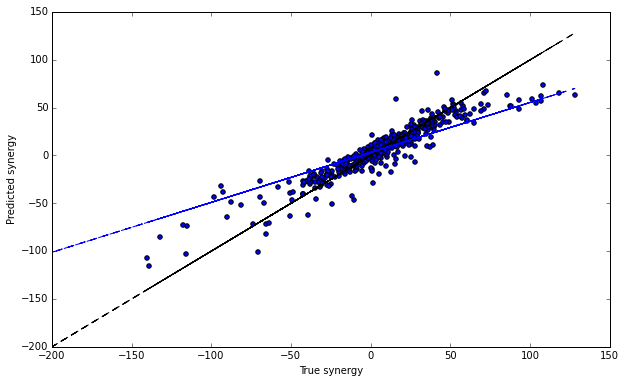

In [100]:
x = y_test
y = gbr.predict(X_test)
plt.scatter(x, y)
plt.plot(x, x, 'k--')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, 'b--')

plt.axis([-200, 150, -200, 150])
plt.xlabel("True synergy")
plt.ylabel("Predicted synergy")
plt.show()

## Classification

In [101]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [141]:
Xstand = StandardScaler().fit_transform(Xvals)

In [152]:
def svm_pred():
    Yclass = Ypd > 0
    Yclass = Yclass.astype(int)
    Yvals = Yclass.values

#     m = Ypd.shape[0]
#     Yvals = np.zeros(m)
#     for i in range(m):
#         if Ypd[i] > 50:
#             Yvals[i] = 1
#         elif Ypd[i] < -50:
#             Yvals[i] = -1
#         else:
#             Yvals[i] = 0
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xstand, Yvals)
    
    svm = SVC() #(C=10, gamma=0.001)
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    print("Classification accuracy: " + str(svm.score(X_test, y_test)))
    print("AUC: " + str(metrics.roc_auc_score(y_test, pred)))

In [153]:
svm_pred()

Classification accuracy: 0.667903525046
AUC: 0.60544242389


In [83]:
def grid_search_svm():
    params = {
        'C': [1, 5, 10],
        'gamma': [0.005, 0.001, 0.0005]
    }
    svc = SVC()
    
    Yclass = Ypd > 0
    Yclass = Yclass.astype(int)
    Yvals = Yclass.values
    
    search = GridSearchCV(svc, params, n_jobs=2)
    for i in range(3):
        search.fit(Xstand, Yvals)
        print(search.best_params_)
        print(search.best_score_)

In [84]:
grid_search_svm()

{'gamma': 0.001, 'C': 10}
0.836118848654
{'gamma': 0.001, 'C': 10}
0.836118848654
{'gamma': 0.001, 'C': 10}
0.836118848654
